In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import random_label_cmap, _draw_polygons
from stardist.models import StarDist2D

np.random.seed(6)
lbl_cmap = random_label_cmap()

Using TensorFlow backend.


In [2]:
download_and_extract_zip_file(
    url       = 'https://github.com/mpicbg-csbd/stardist/releases/download/0.1.0/dsb2018.zip',
    targetdir = 'data',
    verbose   = 1,
)

Files found, nothing to download.


In [3]:
X = sorted(glob('data/dsb2018/train/images/*.tif'))
Y = sorted(glob('data/dsb2018/train/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [4]:
X, Y = X[:10], Y[:10]

In [4]:
X = list(map(imread,X))
Y = list(map(imread,Y))

In [6]:
i = min(4, len(X)-1)
img, lbl = X[i], fill_label_holes(Y[i])
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
# assumed axes ordering of img and lbl is: YX(C)

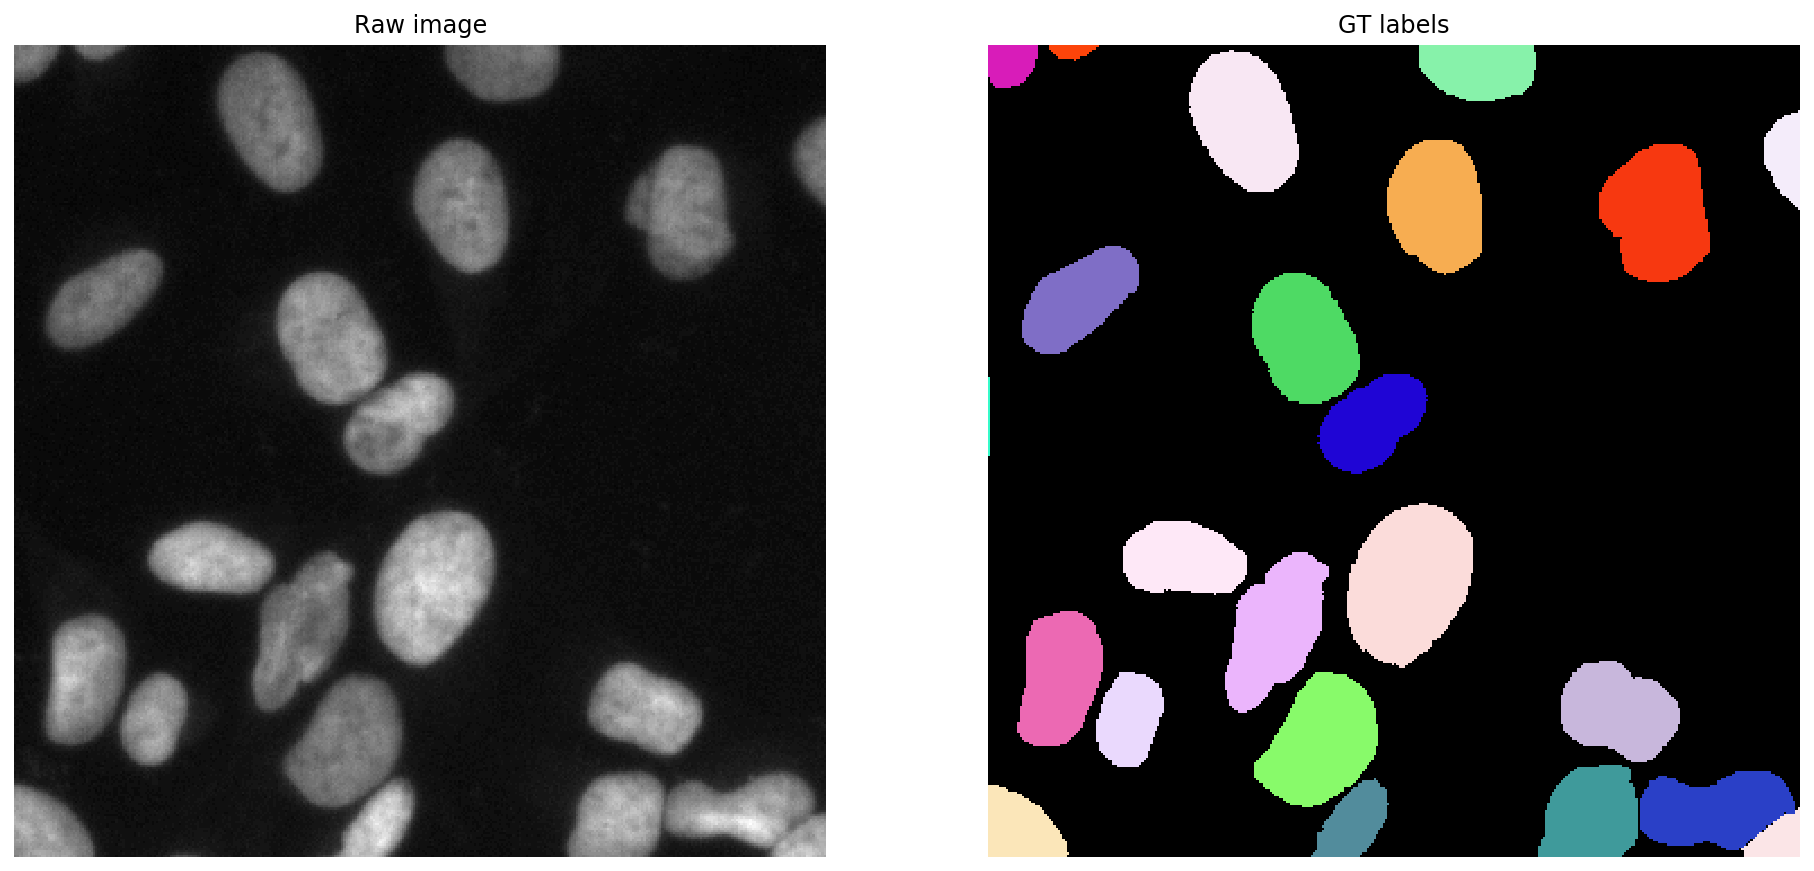

In [7]:
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

In [8]:
n_rays = [2**i for i in range(2,8)]
scores = []
for r in tqdm(n_rays):
    Y_reconstructed = [relabel_image_stardist(lbl, n_rays=r) for lbl in Y]
    mean_iou = matching_dataset(Y, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
    scores.append(mean_iou)

100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


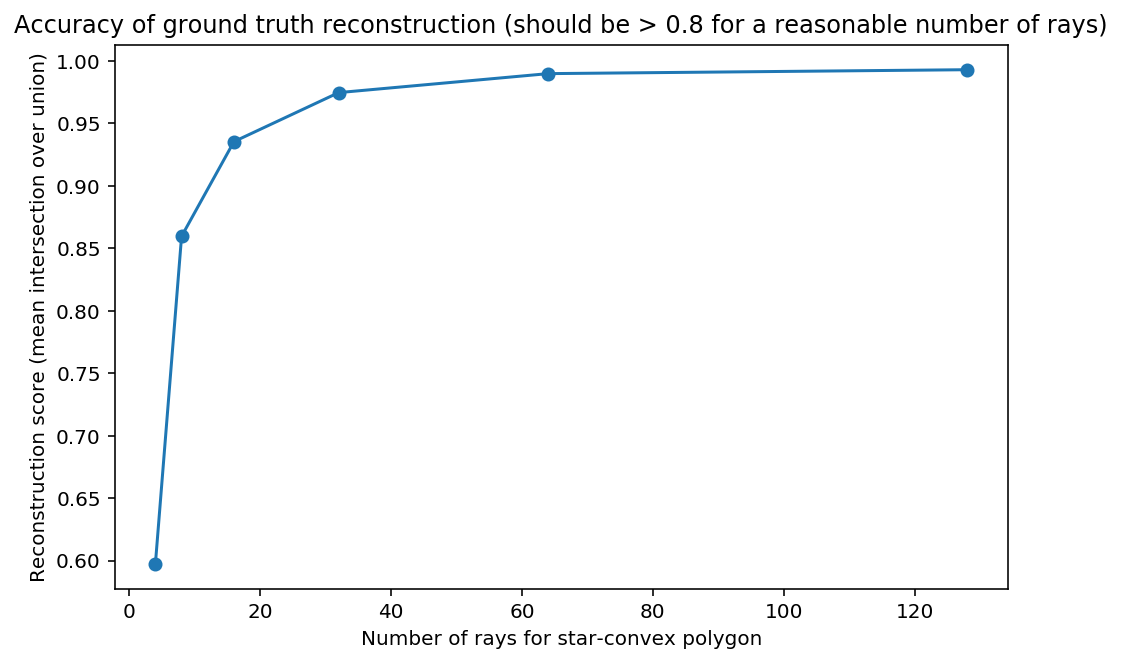

In [9]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores, 'o-')
plt.xlabel('Number of rays for star-convex polygon')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.title("Accuracy of ground truth reconstruction (should be > 0.8 for a reasonable number of rays)")
None;

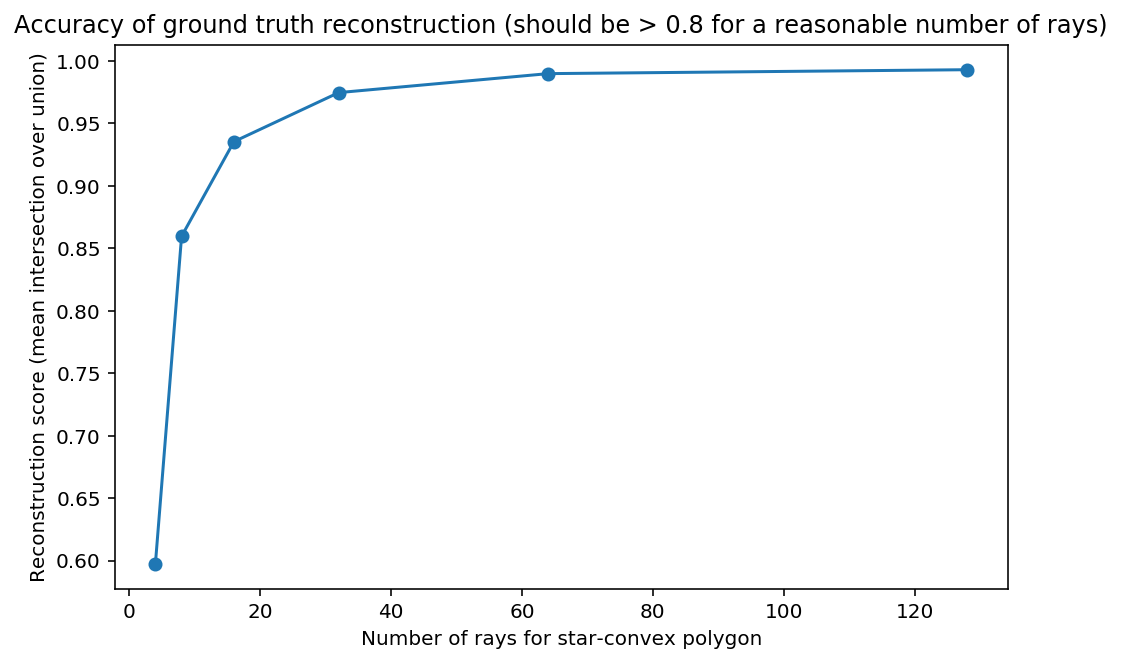

In [10]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores, 'o-')
plt.xlabel('Number of rays for star-convex polygon')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.title("Accuracy of ground truth reconstruction (should be > 0.8 for a reasonable number of rays)")
None;

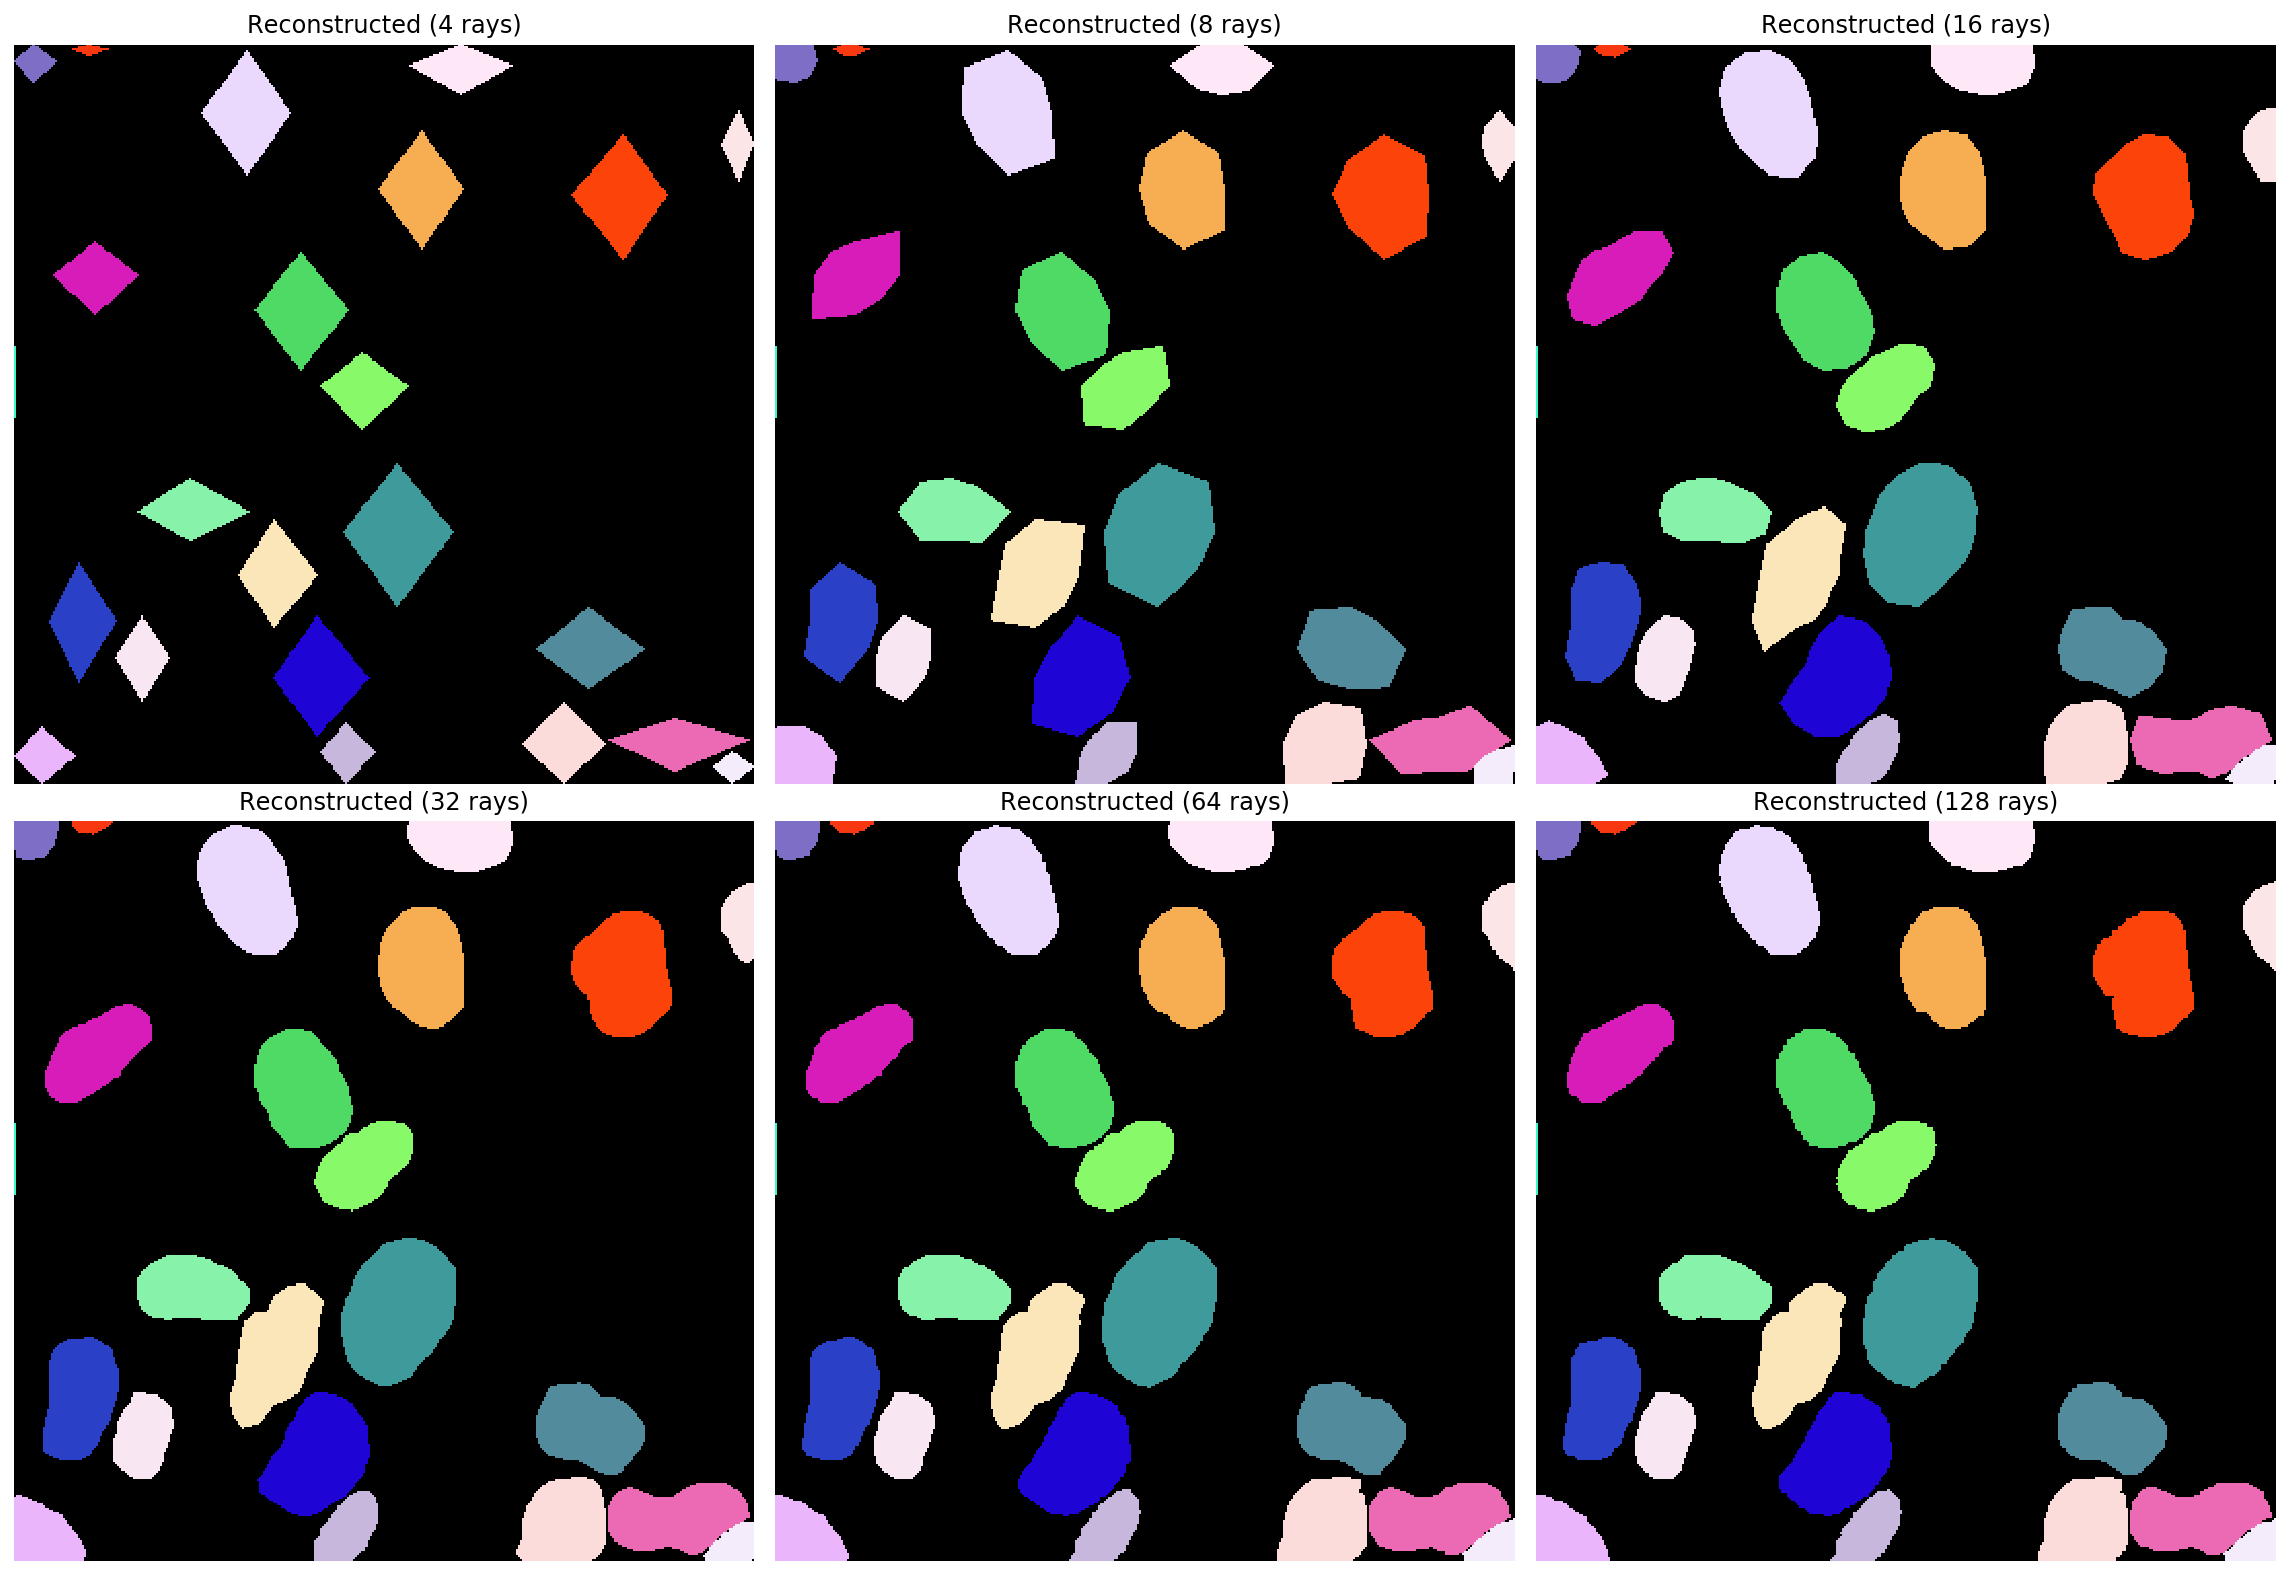

In [11]:
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    a.imshow(relabel_image_stardist(lbl, n_rays=r), cmap=lbl_cmap)
    a.set_title('Reconstructed (%d rays)' % r)
    a.axis('off')
plt.tight_layout();

In [2]:
#-----------------#training#--------------#

from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

Using TensorFlow backend.


In [3]:
X = sorted(glob('data/dsb2018/train/images/*.tif'))
Y = sorted(glob('data/dsb2018/train/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [4]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]


In [5]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 447/447 [00:02<00:00, 222.37it/s]


In [6]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 447
- training:       380
- validation:      67


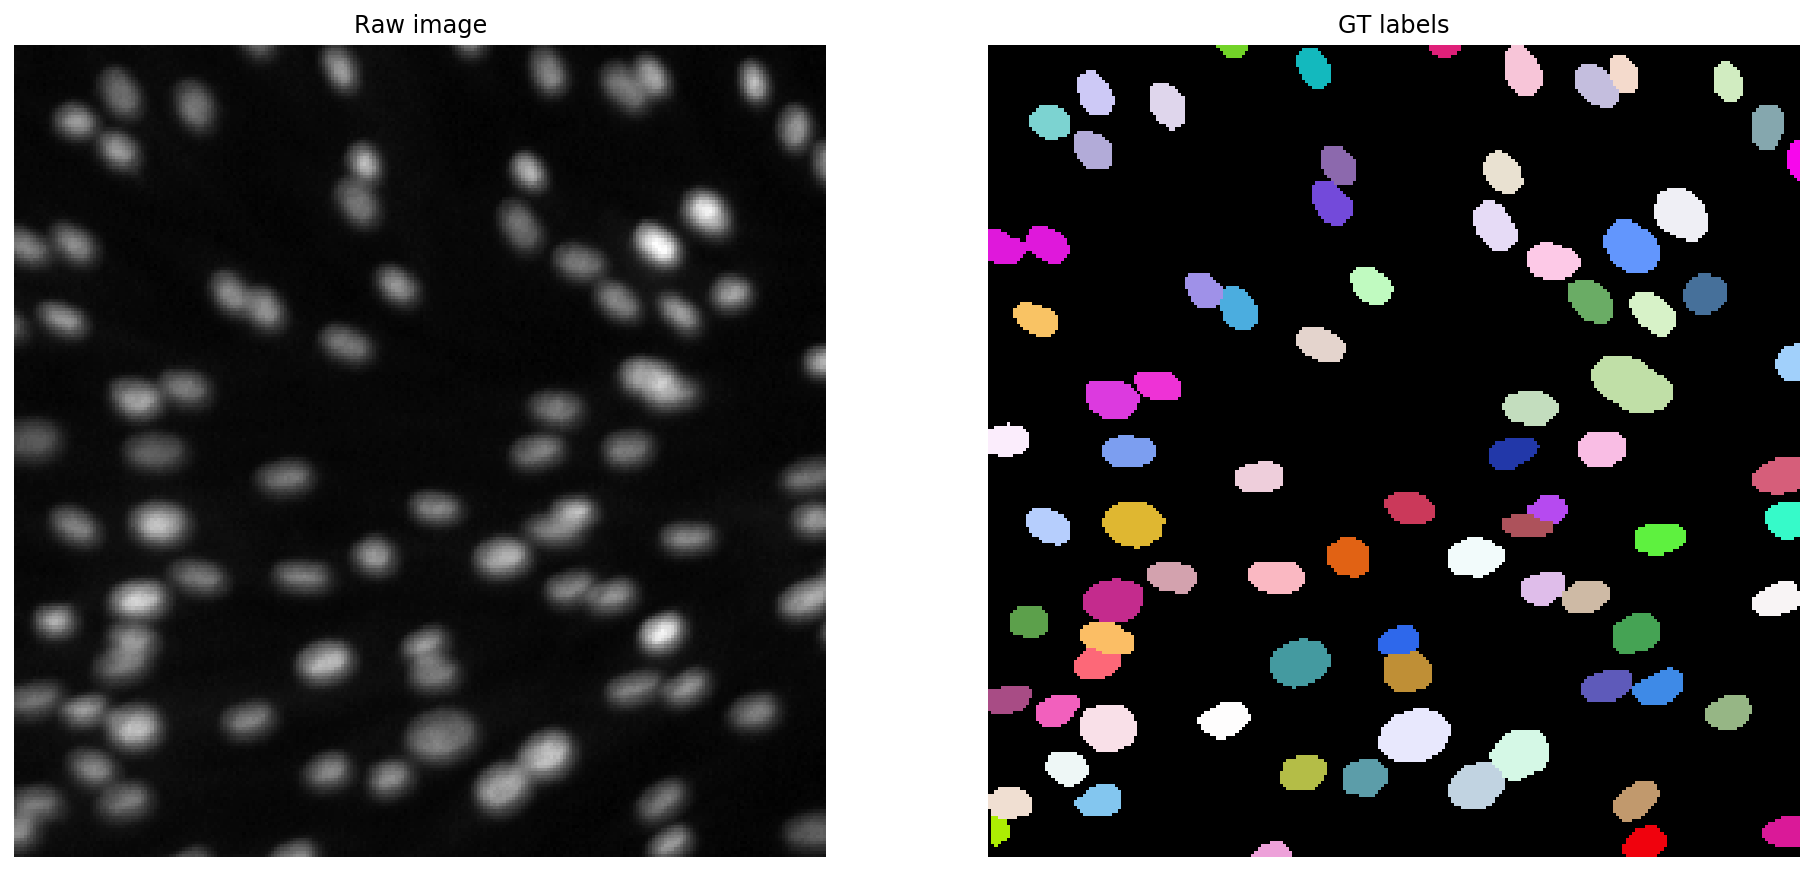

In [7]:

i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

In [8]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
        Convolution kernel size for all (U-Net) convolution layers.
    unet_n_filter_base : int
        Number of convo

In [9]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=False)


{'axes': 'YXC',
 'backbone': 'unet',
 'grid': (2, 2),
 'n_channel_in': 1,
 'n_channel_out': 33,
 'n_dim': 2,
 'n_rays': 32,
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_background_reg': 0.0001,
 'train_batch_size': 4,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_completion_crop': 32,
 'train_dist_loss': 'mae',
 'train_epochs': 400,
 'train_foreground_only': 0.9,
 'train_learning_rate': 0.0003,
 'train_loss_weights': (1, 0.2),
 'train_n_val_patches': None,
 'train_patch_size': (256, 256),
 'train_reduce_lr': {'factor': 0.5, 'min_delta': 0, 'patience': 40},
 'train_shape_completion': False,
 'train_steps_per_epoch': 100,
 'train_tensorboard': True,
 'unet_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_kernel_size': (3, 3),
 'unet_last_activation': 'relu',
 'unet_n_conv_per_depth': 2,
 'unet_n_depth': 3,

In [10]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)

In [11]:
model = (confStarDist2D, name='stardist', basedir='models')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



/home/pwahle/anaconda3/lib/python3.7/site-packages/csbdeep/models/base_model.py:134: UserWarning: output path for model already exists, files may be overwritten: /home/pwahle/Organoid-Image-Analysis/scripts/integration/models/stardist
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [ ]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

In [ ]:
augmenter = None

# def augmenter(x, y):
#     """Augmentation of a single input/label image pair.
#     x is an input image
#     y is the corresponding ground-truth label image
#     """
#     # modify a copy of x and/or y...
#     return x, y

In [10]:
#------------#prediction#-----------# training did not work...
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import random_label_cmap, _draw_polygons
from stardist.models import StarDist2D

np.random.seed(6)
lbl_cmap = random_label_cmap()

Using TensorFlow backend.


In [11]:
X = sorted(glob('data/dsb2018/test/images/*.tif'))
X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

In [12]:

# show all test images
if False:
    fig, ax = plt.subplots(7,8, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

In [19]:
model = StarDist2D(None, name='mock', basedir='../../model')



Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Using default values: prob_thresh=0.5, nms_thresh=0.4.


/home/pwahle/anaconda3/lib/python3.7/site-packages/csbdeep/models/base_model.py:148: UserWarning: Couldn't find any network weights (*.h5, *.hdf5) to load.
  warnings.warn("Couldn't find any network weights (%s) to load." % ', '.join(weights_ext))


In [20]:
img = normalize(X[16], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

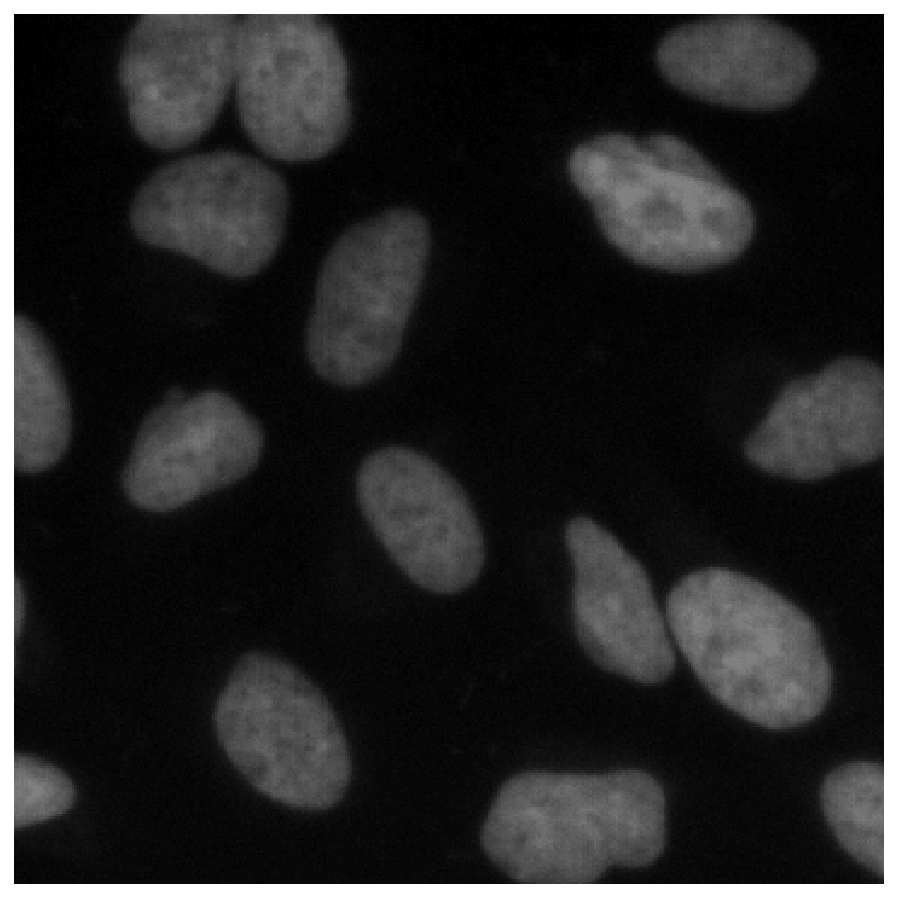

In [21]:
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');